In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import dask
import dask.dataframe as dd

In [2]:
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.initializers import GlorotNormal
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.regularizers import Regularizer

In [3]:
# from my previous assignments and AAIC reference notebooks
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [3]:
train_data=dd.read_csv('/content/drive/MyDrive/Colab Notebooks/Instacart_train.csv')
train_data.head()

,Unnamed: 0,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order,days_since_last_ordered,u_p_count_L5,max_gap_L5,mean_gap_L5,median_gap_L5,std_gap_L5,u_p_ratio_aft_first_L5,u_p_count,max_gap,mean_gap,median_gap,std_gap,u_p_ratio_aft_first,streak,max_sim_top3,sum_of_sim_top3,prod_of_sim_top3,num_of_times_ordered,mean_dow,median_hod,avg_num_of_times_prod_ordered
0,0,1,196,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,14.0,5.0,30.0,16.0,17.0,10.86278,1.0,10,30.0,19.555556,20.0,8.858281,1.0,10,1.000000,2.840198,0.846383,35791,2.898550,12.0,4.473875
1,1,1,12427,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,14.0,5.0,30.0,16.0,17.0,10.86278,1.0,10,30.0,19.555556,20.0,8.858281,1.0,10,1.000000,2.920164,0.921089,6476,2.670784,12.0,3.857058
2,2,1,14084,0.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,190.0,0.0,-1.0,-1.0,-1.0,-1.00000,0.0,1,-1.0,-1.000000,-1.0,-1.000000,0.1,1,0.122681,0.318864,0.001171,15935,2.697082,13.0,5.290505
3,3,1,26088,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,175.0,0.0,-1.0,-1.0,-1.0,-1.00000,0.0,2,15.0,15.000000,15.0,0.000000,0.2,2,0.845998,2.251352,0.410011,2523,2.931431,13.0,2.169390
4,4,1,26405,1.0,1187899.0,10,9.0,1.0,18,10.0,0.555556,19.555556,20.0,8.858281,125.0,0.0,-1.0,-1.0,-1.0,-1.00000,0.0,2,65.0,65.000000,65.0,0.000000,0.2,1,0.790627,2.070992,0.315211,1214,2.765239,12.0,1.790560


In [4]:
test_data=dd.read_csv('/content/drive/MyDrive/Colab Notebooks/Instacart_test.csv')
test_data.head()

,Unnamed: 0,user_id,order_id,product_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order,days_since_last_ordered,u_p_count_L5,max_gap_L5,mean_gap_L5,median_gap_L5,std_gap_L5,u_p_ratio_aft_first_L5,u_p_count,max_gap,mean_gap,median_gap,std_gap,u_p_ratio_aft_first,streak,max_sim_top3,sum_of_sim_top3,prod_of_sim_top3,num_of_times_ordered,mean_dow,median_hod,avg_num_of_times_prod_ordered
0,0,3,2774568,9387,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,68.0,0.0,-1.0,-1.0,-1.0,-1.0,0.000000,5,50.0,19.0,9.5,18.013884,0.416667,4,0.374342,0.299991,2.927135e-04,36187,2.677177,13.0,2.860632
1,1,3,2774568,15143,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,144.0,0.0,-1.0,-1.0,-1.0,-1.0,0.000000,1,-1.0,-1.0,-1.0,-1.000000,0.083333,1,0.237559,0.101456,8.945995e-04,3447,2.752248,13.0,1.968589
2,2,3,2774568,16797,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,54.0,1.0,-1.0,-1.0,-1.0,-1.0,0.250000,3,76.0,45.0,45.0,31.000000,0.250000,1,0.005186,-0.011629,-3.381524e-08,142951,2.721569,13.0,3.312962
3,3,3,2774568,17668,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,26.0,2.0,11.0,11.0,11.0,0.0,0.666667,5,53.0,29.5,28.0,19.716744,0.416667,2,0.576782,0.822771,6.108316e-03,2110,2.840284,14.0,2.370787
4,4,3,2774568,21903,12,11.0,1.0,33,19.0,0.575758,12.090909,11.0,5.124887,11.0,3.0,35.0,25.0,25.0,10.0,0.600000,8,35.0,19.0,15.0,10.099505,0.666667,3,1.000000,1.075832,-5.497061e-04,241921,2.620570,13.0,4.395607


## **Train Test Split**

In [5]:
y=train_data.reordered.values.compute()
x=train_data.drop(['Unnamed: 0','user_id','product_id','reordered','order_id'],axis=1).values.compute()
ss=StandardScaler()
data_scaled=ss.fit_transform(X=x)

In [6]:
X_tr,X_test,y_tr,y_test=train_test_split(data_scaled,y,test_size=0.5,stratify=y,random_state=1)
X_train,X_cv,y_train,y_cv=train_test_split(X_tr,y_tr,test_size=0.2,stratify=y_tr,random_state=1)

In [7]:
X_train.shape,X_cv.shape,X_test.shape

((3389864, 30), (847466, 30), (4237331, 30))

In [6]:
import gc

In [7]:
del train_data
gc.collect()

650

In [ ]:
del test_data
gc.collect()

88

# **Modelling**

## ***Model-1(5-layered Neural Network)***

In [ ]:
class callback_modifications(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        
        y_prob_cv=self.model.predict(X_cv)
        y_pred_cv=[]
        for i in y_prob_cv:
            if i>=0.5:
                y_pred_cv.append(1)
            else:
                y_pred_cv.append(0)
        
        f1_cv=f1_score(y_cv,y_pred_cv)
        print("f1 score of '1=will reorder on cv': {}".format(f1_cv))
        if f1_cv>=0.3:
          # Saves model when f1-score greater than or equal to 0.3 is seen.
          file_path='/content/drive/MyDrive/Colab Notebooks/Deep Learning Models/model_1/model_5_layered_NN_7L_param_epoch'+str(epoch+1)+'.h5'
          self.model.save(file_path)
          print('model saved')
        print('*'*50)
        
            
callback_modif=callback_modifications()

In [ ]:
model_1= Sequential()
model_1.add(Dense(1024, activation='relu', input_dim=X_train.shape[1], kernel_initializer=HeNormal(seed=None),kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_1.add(Dense(512, activation='relu',kernel_initializer=HeNormal(seed=None),kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_1.add(Dropout(0.2))
model_1.add(Dense(256, activation='relu',kernel_initializer=HeNormal(seed=None),kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_1.add(Dropout(0.3))
model_1.add(Dense(128, activation='relu',kernel_initializer=HeNormal(seed=None),kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_1.add(Dense(64, activation='relu',kernel_initializer=HeNormal(seed=None),kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_1.add(Dense(1, activation='sigmoid'))

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              31744     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8

In [ ]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [ ]:
model_1.fit(X_train,y_train,batch_size=256,epochs=100,verbose=1,validation_data=(X_cv,y_cv),callbacks=[callback_modif])

Epoch 1/100
13242/13242 [==============================] - 84s 6ms/step - loss: 1.9265 - accuracy: 0.9047 - val_loss: 0.2733 - val_accuracy: 0.9078
f1 score of '1=will reorder on cv': 0.22491026988439192
**************************************************
Epoch 2/100
13242/13242 [==============================] - 83s 6ms/step - loss: 0.2751 - accuracy: 0.9063 - val_loss: 0.2721 - val_accuracy: 0.9073
f1 score of '1=will reorder on cv': 0.29573840456913325
**************************************************
Epoch 3/100
13242/13242 [==============================] - 84s 6ms/step - loss: 0.2721 - accuracy: 0.9066 - val_loss: 0.2680 - val_accuracy: 0.9070
f1 score of '1=will reorder on cv': 0.16959372562248318
**************************************************
Epoch 4/100
13242/13242 [==============================] - 83s 6ms/step - loss: 0.2706 - accuracy: 0.9069 - val_loss: 0.2683 - val_accuracy: 0.9078
f1 score of '1=will reorder on cv': 0.2688232431015763
********************************

In [25]:
from keras.models import load_model
model_1=load_model(r"/content/drive/MyDrive/Colab Notebooks/Deep Learning Models/model_1/model_5_layered_NN_7L_param_epoch69.h5")

### ***Tuning Probability Thresholds***

In [ ]:
threshold_1=[0.1,0.2,0.3,0.4,0.5]
for thres in threshold_1:
  y_pred=[]
  for i in model_1.predict(X_cv):
    if i>=thres:
      y_pred.append(1)
    else:
      y_pred.append(0)
  f1_cv=f1_score(y_cv,y_pred)
  print("f1_score of '1=will reorder' with threshold={} is: {}".format(thres,f1_cv))

f1_score of '1=will reorder' with threshold=0.1 is: 0.3319588540873147
f1_score of '1=will reorder' with threshold=0.2 is: 0.4084077534535739
f1_score of '1=will reorder' with threshold=0.3 is: 0.4300274141067357
f1_score of '1=will reorder' with threshold=0.4 is: 0.4179165916282898
f1_score of '1=will reorder' with threshold=0.5 is: 0.36555603634790135


In [26]:
threshold_2=[0.27,0.28,0.29,0.3,0.31,0.32,0.33]
f1_scores=[]
for thres in threshold_2:
  y_pred=[]
  for i in model_1.predict(X_cv):
    if i>=thres:
      y_pred.append(1)
    else:
      y_pred.append(0)
  f1_cv=f1_score(y_cv,y_pred)
  f1_scores.append(f1_cv)
  print("f1_score of '1=will reorder' with threshold={} is: {}".format(thres,f1_cv))

f1_score of '1=will reorder' with threshold=0.27 is: 0.42638717632552403
f1_score of '1=will reorder' with threshold=0.28 is: 0.4277019262606392
f1_score of '1=will reorder' with threshold=0.29 is: 0.42904755480270024
f1_score of '1=will reorder' with threshold=0.3 is: 0.4300274141067357
f1_score of '1=will reorder' with threshold=0.31 is: 0.4302128263188034
f1_score of '1=will reorder' with threshold=0.32 is: 0.4306208754208754
f1_score of '1=will reorder' with threshold=0.33 is: 0.4301255784672137


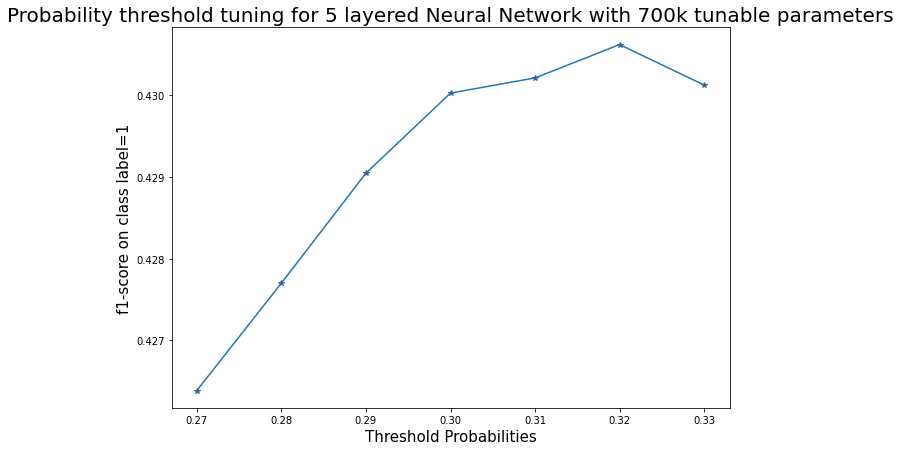

In [27]:
plt.figure(figsize=(10,7))
plt.plot(threshold_2,f1_scores,marker='*',mfc='r')
plt.xlabel('Threshold Probabilities',size=15)
plt.ylabel('f1-score on class label=1',size=15)
plt.title('Probability threshold tuning for 5 layered Neural Network with 700k tunable parameters',size=20)
plt.show()

### ***Optimum Threshold(5 layered Neural Network)***: 0.32

In [28]:
y_pred_NN_7L_param_train=[1 if i>=0.32 else 0 for i in model_1.predict(X_train)]
y_pred_NN_7L_param_test=[1 if i>=0.32 else 0 for i in model_1.predict(X_test)]
print('f1-score on train data: {}'.format(f1_score(y_train,y_pred_NN_7L_param_train,average=None)))
print('f1-score on test data: {}'.format(f1_score(y_test,y_pred_NN_7L_param_test,average=None)))

f1-score on train data: [0.93005417 0.43092903]
f1-score on test data: [0.93018694 0.43219423]


Train data


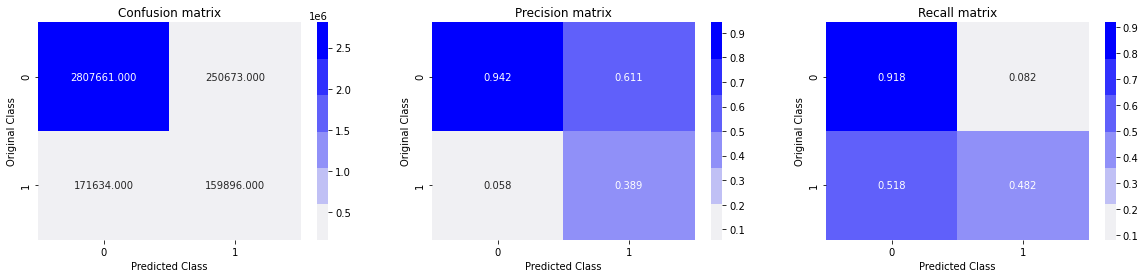

Test data


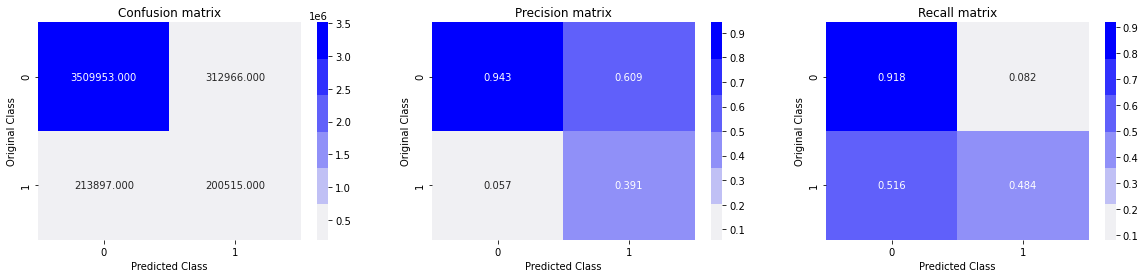

In [29]:
# Confusion, Precision and Recall matrices on train and test data predictions
print('Train data')
plot_confusion_matrix(y_train,y_pred_NN_7L_param_train)
print('Test data')
plot_confusion_matrix(y_test,y_pred_NN_7L_param_test)

### ***Model-1 => 5 layered deep Neural Network with around 7 lakh tunable parameters:***

* ***Optimum probability threshold    :*** 0.32
* ***Test f1-score of '1=will reorder':*** 0.4321
* ***Test recall of '1=will reorder'  :*** 0.484
* ***Model did not over-fit to train data***

### ***Model-1 Kaggle Submission***

<img src="Kaggle Submission Screenshots/5 NN.png">

## ***Model-2(6-layered Neural Network)***

In [ ]:
class callback_modifications(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        
        y_prob_cv=self.model.predict(X_cv)
        y_pred_cv=[]
        for i in y_prob_cv:
            if i>=0.5:
                y_pred_cv.append(1)
            else:
                y_pred_cv.append(0)
        
        f1_cv=f1_score(y_cv,y_pred_cv)
        print("f1 score of '1=will reorder on cv': {}".format(f1_cv))
        if f1_cv>=0.3:
          file_path='/content/drive/MyDrive/Colab Notebooks/Deep Learning Models/model_2/model_6_layered_NN_28L_param_epoch'+str(epoch+1)+'.h5'
          self.model.save(file_path)
          print('model saved')
        print('*'*50)
        
            
callback_modif=callback_modifications()

In [ ]:
model_2= Sequential()
model_2.add(Dense(2048, activation='relu', input_dim=X_train.shape[1], kernel_initializer=HeNormal(seed=None),kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_2.add(Dense(1024, activation='relu', kernel_initializer=HeNormal(seed=None),kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_2.add(Dropout(0.15))
model_2.add(Dense(512, activation='relu',kernel_initializer=HeNormal(seed=None),kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_2.add(Dropout(0.2))
model_2.add(Dense(256, activation='relu',kernel_initializer=HeNormal(seed=None),kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_2.add(Dropout(0.3))
model_2.add(Dense(128, activation='relu',kernel_initializer=HeNormal(seed=None),kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_2.add(Dense(64, activation='relu',kernel_initializer=HeNormal(seed=None),kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_2.add(Dense(1, activation='sigmoid'))

In [ ]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              63488     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [ ]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [ ]:
model_2.fit(X_train,y_train,batch_size=256,epochs=100,verbose=1,validation_data=(X_cv,y_cv),callbacks=[callback_modif])

Epoch 1/100
13242/13242 [==============================] - 66s 5ms/step - loss: 3.3722 - accuracy: 0.9031 - val_loss: 0.2807 - val_accuracy: 0.9070
f1 score of '1=will reorder on cv': 0.16461637899064388
**************************************************
Epoch 2/100
13242/13242 [==============================] - 63s 5ms/step - loss: 0.2838 - accuracy: 0.9048 - val_loss: 0.2806 - val_accuracy: 0.9067
f1 score of '1=will reorder on cv': 0.31532927599968835
model saved
**************************************************
Epoch 3/100
13242/13242 [==============================] - 62s 5ms/step - loss: 0.2811 - accuracy: 0.9050 - val_loss: 0.2923 - val_accuracy: 0.9025
f1 score of '1=will reorder on cv': 0.008760560675883256
**************************************************
Epoch 4/100
13242/13242 [==============================] - 63s 5ms/step - loss: 0.2801 - accuracy: 0.9047 - val_loss: 0.2740 - val_accuracy: 0.9053
f1 score of '1=will reorder on cv': 0.09572083488212302
******************

In [ ]:
model_2.save(r'/content/drive/MyDrive/Colab Notebooks/Deep Learning Models/model_2/model_6_layered_NN_28L_param_epoch_last.h5')

In [8]:
from keras.models import load_model
model_2=load_model(r"/content/drive/MyDrive/Colab Notebooks/Deep Learning Models/model_2/model_6_layered_NN_28L_param_epoch75.h5")

### ***Tuning Probability Thresholds***

In [20]:
threshold_1=[0.1,0.2,0.3,0.4,0.5]
for thres in threshold_1:
  y_pred=[]
  for i in model_2.predict(X_cv):
    if i>=thres:
      y_pred.append(1)
    else:
      y_pred.append(0)
  f1_cv=f1_score(y_cv,y_pred)
  print("f1_score of '1=will reorder' with threshold={} is: {}".format(thres,f1_cv))

f1_score of '1=will reorder' with threshold=0.1 is: 0.34891763592763575
f1_score of '1=will reorder' with threshold=0.2 is: 0.413669273576221
f1_score of '1=will reorder' with threshold=0.3 is: 0.42759844415231724
f1_score of '1=will reorder' with threshold=0.4 is: 0.4135014055941363
f1_score of '1=will reorder' with threshold=0.5 is: 0.3782511527067261


In [21]:
threshold_2=[0.27,0.28,0.29,0.3,0.31,0.32,0.33]
f1_scores=[]
for thres in threshold_2:
  y_pred=[]
  for i in model_2.predict(X_cv):
    if i>=thres:
      y_pred.append(1)
    else:
      y_pred.append(0)
  f1_cv=f1_score(y_cv,y_pred)
  f1_scores.append(f1_cv)
  print("f1_score of '1=will reorder' with threshold={} is: {}".format(thres,f1_cv))

f1_score of '1=will reorder' with threshold=0.27 is: 0.4274245864417775
f1_score of '1=will reorder' with threshold=0.28 is: 0.4273771988051776
f1_score of '1=will reorder' with threshold=0.29 is: 0.4273770543917093
f1_score of '1=will reorder' with threshold=0.3 is: 0.42759844415231724
f1_score of '1=will reorder' with threshold=0.31 is: 0.42731078051312643
f1_score of '1=will reorder' with threshold=0.32 is: 0.4264183448842747
f1_score of '1=will reorder' with threshold=0.33 is: 0.4254123368430711


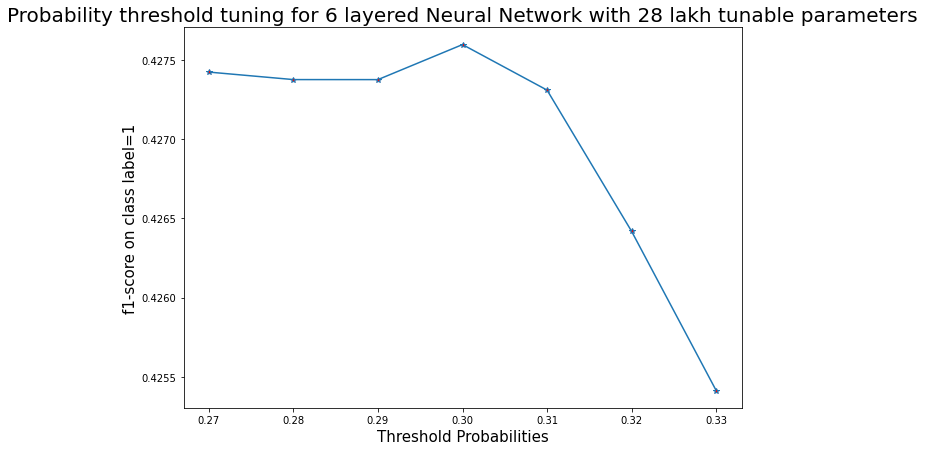

In [22]:
plt.figure(figsize=(10,7))
plt.plot(threshold_2,f1_scores,marker='*',mfc='r')
plt.xlabel('Threshold Probabilities',size=15)
plt.ylabel('f1-score on class label=1',size=15)
plt.title('Probability threshold tuning for 6 layered Neural Network with 28 lakh tunable parameters',size=20)
plt.show()

### ***Optimum Threshold(6 layered Neural Network)***: 0.3

In [23]:
y_pred_NN_6_layered_train=[1 if i>=0.3 else 0 for i in model_2.predict(X_train)]
y_pred_NN_6_layered_test=[1 if i>=0.3 else 0 for i in model_2.predict(X_test)]
print('f1-score on train data: {}'.format(f1_score(y_train,y_pred_NN_6_layered_train,average=None)))
print('f1-score on test data: {}'.format(f1_score(y_test,y_pred_NN_6_layered_test,average=None)))

f1-score on train data: [0.92985557 0.42728878]
f1-score on test data: [0.93005697 0.42874544]


Train data


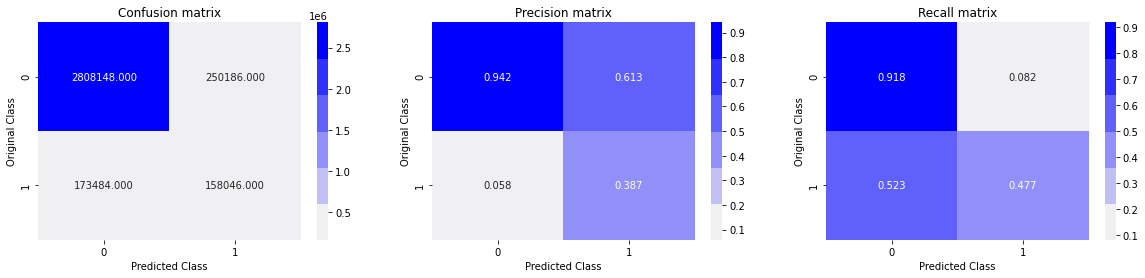

Test data


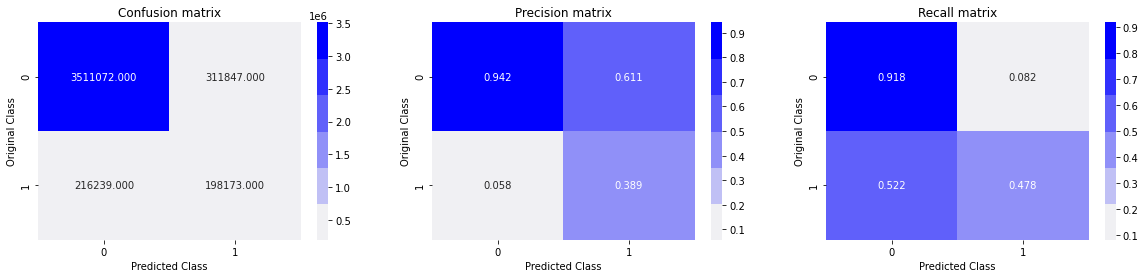

In [24]:
# Confusion, Precision and Recall matrices on train and test data predictions
print('Train data')
plot_confusion_matrix(y_train,y_pred_NN_6_layered_train)
print('Test data')
plot_confusion_matrix(y_test,y_pred_NN_6_layered_test)

### ***Model-2 => 6 layered deep Neural Network with around 28 lakh tunable parameters:***

* ***Optimum probability threshold    :*** 0.3
* ***Test f1-score of '1=will reorder':*** 0.4287
* ***Test recall of '1=will reorder'  :*** 0.478
* ***Model did not over-fit to train data***

<img src="Kaggle Submission Screenshots/6 NN.png">